In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
from scipy.ndimage import binary_dilation
import warnings

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_dir = 'data'

def load_mnist_file(filename):
    path = os.path.join(data_dir, filename)
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
        
    with open(path, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        if magic == 2051: # Images
            rows, cols = struct.unpack(">II", f.read(8))
            data = np.fromfile(f, dtype=np.uint8)
            return data.reshape(num, rows, cols)
        elif magic == 2049: # Labels
            data = np.fromfile(f, dtype=np.uint8)
            return data
        else:
            raise ValueError(f"Invalid magic number {magic} in {filename}")

try:
    X_train = load_mnist_file('train-images.idx3-ubyte')
    y_train = load_mnist_file('train-labels.idx1-ubyte')
    X_test = load_mnist_file('t10k-images.idx3-ubyte')
    y_test = load_mnist_file('t10k-labels.idx1-ubyte')
    print("Data loaded")
except FileNotFoundError as e:
    print(e)


Data loaded


Training set overview

In [3]:
# Check Shapes
print(f"Shape of Images: {X_train.shape} (N, Height, Width)")
print(f"Shape of Labels: {y_train.shape}")

# Check Data Types
print(f"Data Type: {X_train.dtype}")

# Check for Missing Values (NaNs)
has_nans = np.isnan(X_train).any()
print(f"Contains NaNs: {has_nans}")

# Value Range Analysis
min_val, max_val = X_train.min(), X_train.max()
print(f"Pixel Value Range: {min_val} to {max_val}")
print(f"Mean Pixel Value: {X_train.mean():.2f}")
print(f"Std Dev Pixel Value: {X_train.std():.2f}")

Shape of Images: (60000, 28, 28) (N, Height, Width)
Shape of Labels: (60000,)
Data Type: uint8
Contains NaNs: False
Pixel Value Range: 0 to 255
Mean Pixel Value: 33.32
Std Dev Pixel Value: 78.57


Class distribution

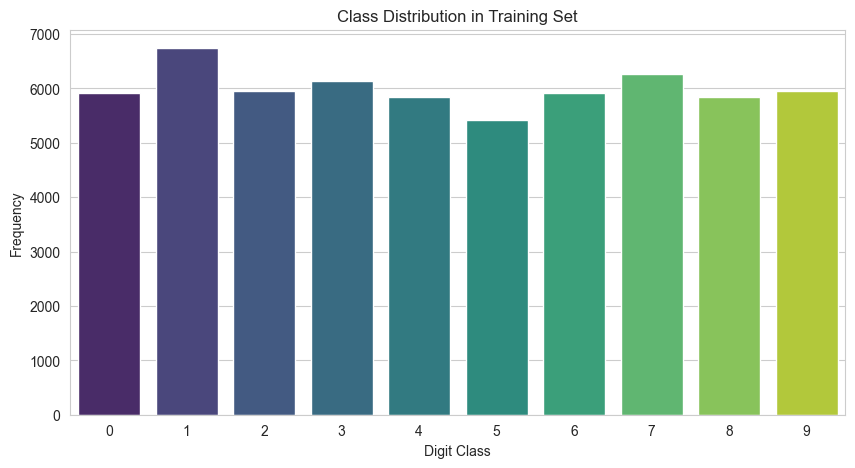

In [4]:
unique, counts = np.unique(y_train, return_counts=True)
class_dist = dict(zip(unique, counts))

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_dist.keys()), y=list(class_dist.values()), palette="viridis")
plt.title("Class Distribution in Training Set")
plt.xlabel("Digit Class")
plt.ylabel("Frequency")
plt.show()

Sample grid

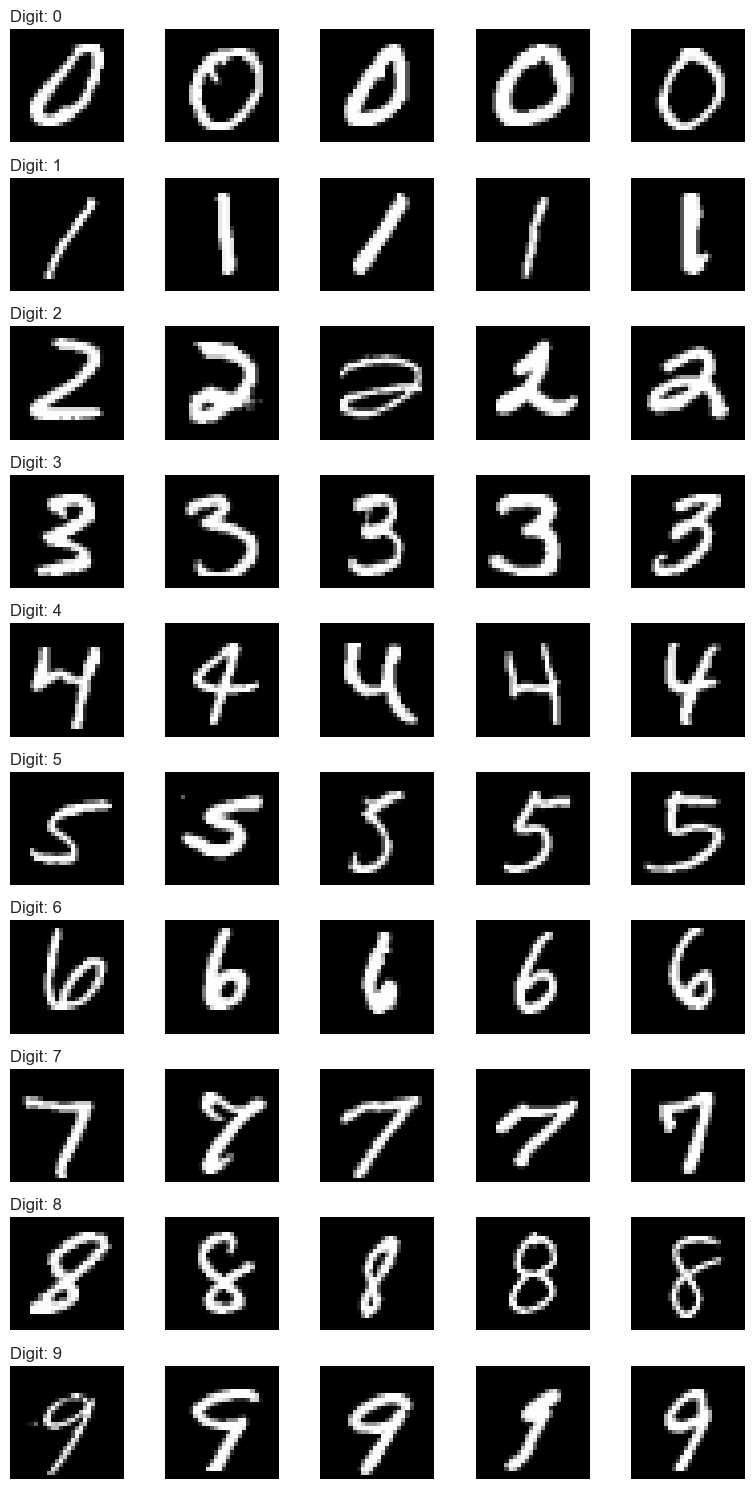

In [5]:
num_samples_per_class = 5
classes = np.unique(y_train)
num_classes = len(classes)

fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(8, 15))

for i, cls in enumerate(classes):
    idxs = np.where(y_train == cls)[0]
    samples = np.random.choice(idxs, num_samples_per_class, replace=False)
    
    for j, idx in enumerate(samples):
        ax = axes[i, j]
        ax.imshow(X_train[idx], cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_title(f"Digit: {cls}", loc='left', fontsize=12)

plt.tight_layout()
plt.show()

Average digit heatmap

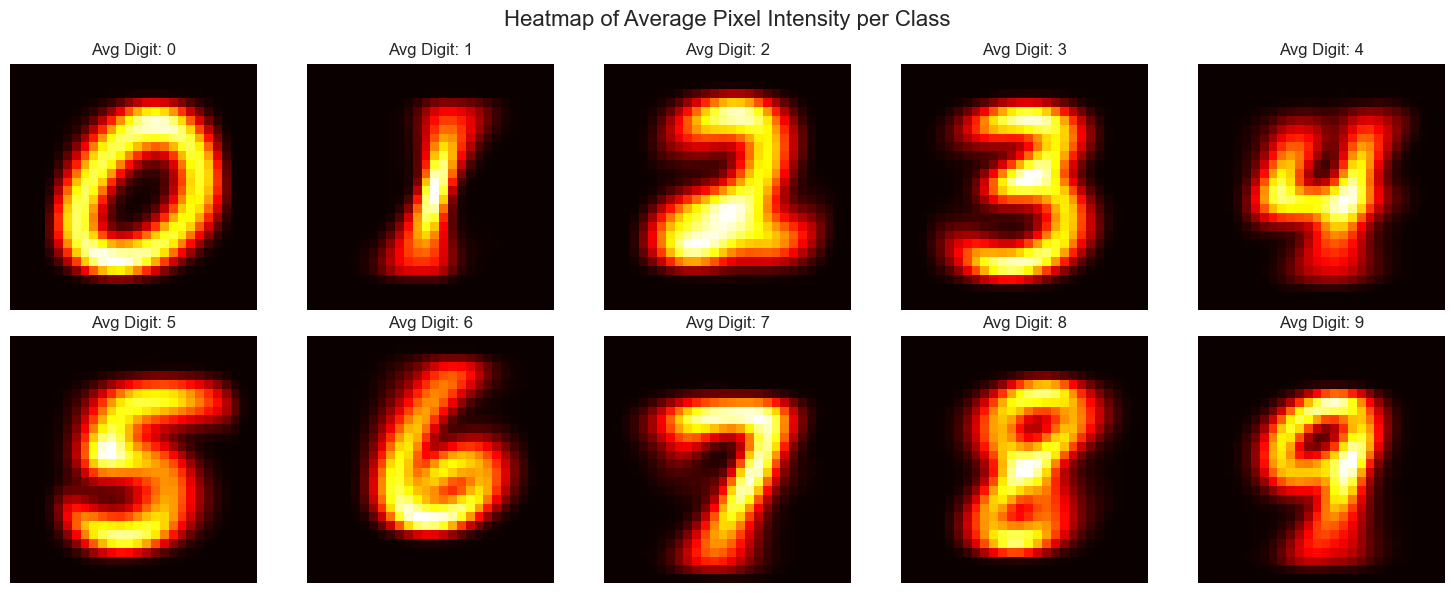

In [6]:
classes = np.unique(y_train)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, cls in enumerate(classes):
    idxs = np.where(y_train == cls)[0]
    mean_img = np.mean(X_train[idxs], axis=0)
    
    axes[i].imshow(mean_img, cmap='hot')
    axes[i].set_title(f"Avg Digit: {cls}")
    axes[i].axis('off')
    
plt.suptitle("Heatmap of Average Pixel Intensity per Class", fontsize=16)
plt.tight_layout()
plt.show()

Images with isolated floating specks/dust: 595 / 60000


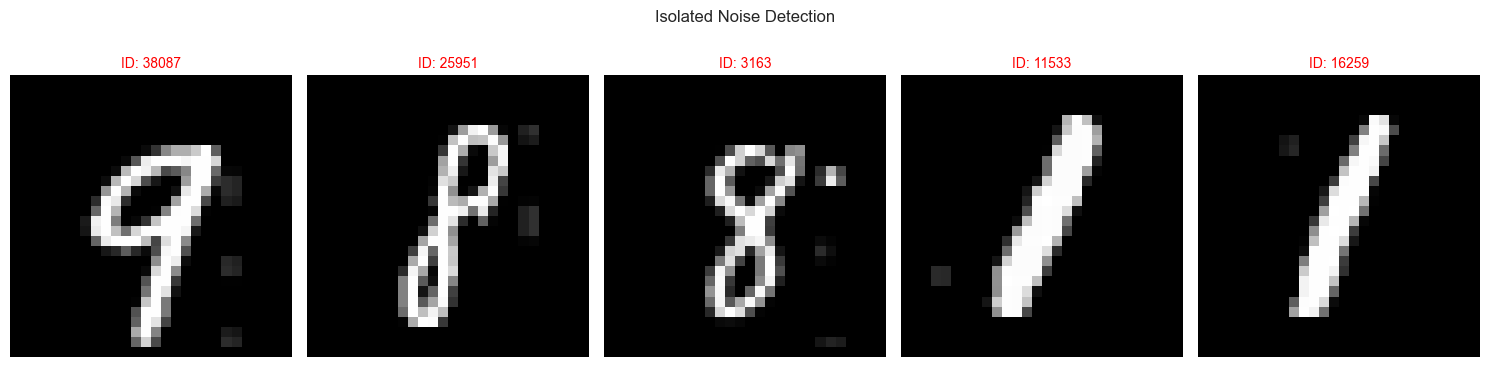

In [7]:
noise_map = []

# Process images to find isolated "dust"
# We define dust as pixels > 15 intensity that are NOT connected to the main digit (> 50 intensity)
for i in range(len(X_train)):
    img = X_train[i]
    
    # 1. Identify core digit structure
    core_stroke = img > 50
    
    # 2. Expand structure slightly to include valid anti-aliasing (glow)
    valid_zone = binary_dilation(core_stroke, iterations=2)
    
    # 3. Find pixels that are visible but outside the valid zone
    dust = (img > 15) & (~valid_zone)
    
    if np.any(dust):
        noise_map.append((i, np.sum(dust), dust))

# Sort by amount of noise found
noise_map.sort(key=lambda x: x[1], reverse=True)

print(f"Images with isolated floating specks/dust: {len(noise_map)} / {len(X_train)}")

# Visualize Top 5 Worst Offenders
if len(noise_map) > 0:
    num_display = 5
    display_count = min(num_display, len(noise_map))
    
    fig, axes = plt.subplots(1, display_count, figsize=(15, 4))
    if display_count == 1: axes = [axes]
    
    for i in range(display_count):
        idx, count, dust_mask = noise_map[i]
        img = X_train[idx]
        
        axes[i].imshow(img, cmap='gray', vmin=0, vmax=255)

        axes[i].set_title(f"ID: {idx}", color='red', fontsize=10)
        axes[i].axis('off')
        
    plt.suptitle("Isolated Noise Detection", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No isolated dust artifacts detected.")

Pixel intensity distribution

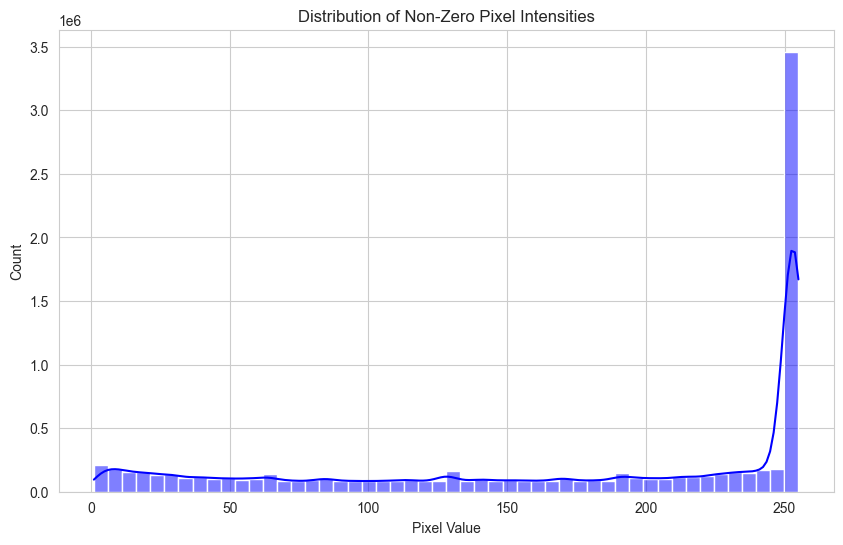

In [8]:
pixels = X_train.flatten()
active_pixels = pixels[pixels > 0]

plt.figure(figsize=(10, 6))
sns.histplot(active_pixels, bins=50, kde=True, color='blue')
plt.title("Distribution of Non-Zero Pixel Intensities")
plt.xlabel("Pixel Value")
plt.show()